# Imports


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from time import time
import torch.nn.functional as F
from sp_sims.simulators.stochasticprocesses import BDStates
from samprecon.environments.OneEpisodeEnvironments import MarkovianUniformEnvironment
from samprecon.samplers.agents import SimpleAgent 
from samprecon.reconstructors.NNReconstructors import RNNReconstructor
from tqdm.notebook import tqdm
import torch

plt.style.use('rose-pine-dawn')
rnd.seed(int(time()))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Generate Environments on which to learn
high_res_delta = 1e-1  # For generating the dataset and later sample
baseline_rates = {"lam": 1 / 10, "mu": 4 / 10}
epochs = 100
lenth_of_episode = 12
step_path_length = 1
sampling_budget = 8
used_path_length = 64  # So that we can let the process reach stationarity and take samples from stationary distribution
num_states = 4
avg_span = np.mean(1 / np.array(list(baseline_rates.values())))
max_decimation = (
    avg_span / high_res_delta
) * 4  # Max decimation factor #CHECK: Maybe not divide by 2
current_decimation_factor = int(  # We can start somewhere in between
    avg_span // high_res_delta
)
print(f"Decimation factor is {current_decimation_factor}")
# Set random seed with time for randomnessj

Decimation factor is 62


In [22]:
# Initialize context first
state_generator = BDStates(baseline_rates, high_res_delta, num_states)
sampling_arbiter = SimpleAgent(sampling_budget, max_decimation)
# sampling_arbiter.initialize_grad_hooks()
reconstructor = RNNReconstructor(
    amnt_states=num_states, max_decimation_rate=max_decimation
)
# reconstructor.initialize_grad_hooks()


env = MarkovianUniformEnvironment(
    state_generator=state_generator,
    sampling_arbiter=sampling_arbiter,
    reconstructor=reconstructor,
    starting_decrate=current_decimation_factor,
    sampling_budget = sampling_budget
)

In [23]:
ebar = tqdm(range(epochs), desc="Epochs", position=0)
e_losses = []
for epoch in range(epochs):
    # We generate a single step from the generator process
    leave = epoch == epochs - 1
    sbar = tqdm(range(lenth_of_episode), desc="Steps", leave=leave, position=1)
    for step in range(lenth_of_episode):
        # with torch.autograd.set_detect_anomaly(True):
        loss, tqdm_bar_info = env.step()
        sbar.set_description(tqdm_bar_info)

        sbar.update(1)
    e_losses = np.append(e_losses, loss)
    moving_avg_loss = np.mean(e_losses[-3:]) if epoch > 3 else np.mean(e_losses)
    ebar.set_description(f"Epoch Mean Loss: {moving_avg_loss}")
    ebar.update(1)
    # We get reward based on how close we got to maximum information

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

/Users/rac716/Research/SamplingReconstruction/samprecon/samplers/spatial_transformers.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(decimation_intervals[i])


Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

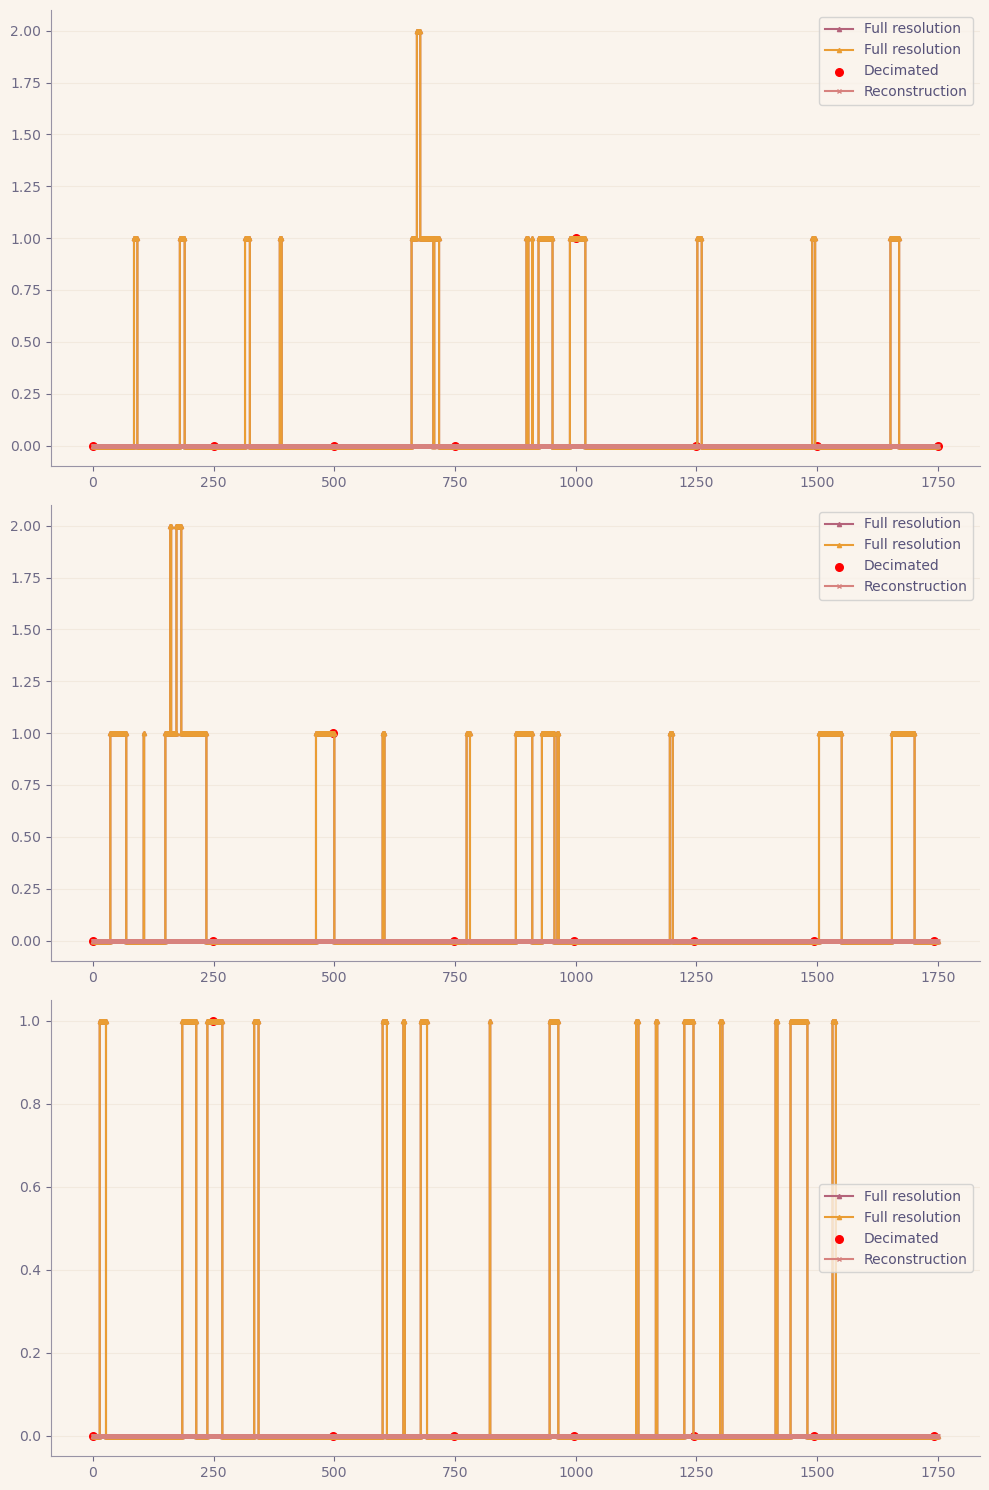

In [45]:
def hard_decimation_of_state(high_freq_signal: torch.Tensor, rate: int, sampling_budget:int, num_classes:int):
    blank_slate = torch.zeros_like(high_freq_signal)
    seq_len = len(blank_slate)
    samples = high_freq_signal[::rate][:sampling_budget]
    for i,sample in enumerate(samples):
        blank_slate[i*rate] = sample
    # turn blank_slate into one hot
    one_hot = F.one_hot(blank_slate.to(torch.long), num_classes=num_classes).view(1,-1,num_classes)
    return one_hot

# Visually confirm proper reconstruction. 
num_examples = 3

fig, axs = plt.subplots(num_examples,1, figsize=(10,15))
# Start with some previous state. 
last_action = current_decimation_factor
prev_state = torch.Tensor(
        state_generator.sample(last_action, sampling_budget)
    ).to(torch.float)



for ne in range(num_examples):

    action: torch.Tensor = sampling_arbiter(
        prev_state[:: int(last_action)]
    ).view(1, -1)

    # New State
    new_state = torch.Tensor(
        state_generator.sample(action, sampling_budget)
    ).to(torch.long)

    # 🛑 Difference lies here:
    dec_state = hard_decimation_of_state(new_state, int(last_action),sampling_budget,num_states)

    reconstruction = reconstructor(
        dec_state,
        action,
    )
    # From probabilities back to arg max 
    reconstruction = torch.argmax(reconstruction, dim=2).view(-1).detach().numpy()

    prev_state = new_state.to(torch.float)
    last_action = action.item()

    # Do plotting here
    axs[ne].plot(np.arange(len(new_state)), new_state, new_state,drawstyle="steps-post",label="Full resolution", marker="^",markersize=3)

    # Plot Samples
    dec_x = np.arange(sampling_budget)*(int(last_action))
    axs[ne].scatter(dec_x, new_state[::int(action)][:sampling_budget], label="Decimated", marker="o",color='r',s=30)

    # Plot Reconstrunction
    axs[ne].plot(np.arange(len(reconstruction)), reconstruction, label="Reconstruction", marker="x",markersize=3)
    axs[ne].legend()
plt.tight_layout()
plt.show()
    
